# imports..

In [1]:
from research.research_engine import build_ResearchEngine
from strategies.vault_rebalancing import YieldStrategy
from strategies.vault_backtest import VaultBacktestEngine
import json
import yaml
import pandas as pd
from copy import deepcopy

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# load data

In [3]:
metadata = pd.read_csv("C:/Users/david/singularity/midfreq/scrappers/defillama_history/data/DynLst_pool_metadata.csv")
with open("C:/Users/david/singularity/midfreq/config/dynlst.yaml") as file:
    parameters= yaml.safe_load(file)
pool_map = metadata.loc[metadata['pool'].isin(parameters['input_data']['selected_instruments']),['pool','project','symbol']].set_index('pool').T.to_dict()
pool_map = {key: '{}_{}'.format(x['project'], x['symbol']) for key, x in pool_map.items()}
index_map = {f'weight_{i}': f'w_{value}' for i, value in enumerate(pool_map.values())}
index_map |= {f'yield_{i}': f'y_{value}' for i, value in enumerate(pool_map.values())} 
pool_map

{'747c1d2a-c668-4682-b9f9-296708a3dd90': 'lido_STETH',
 'd4b3c522-6127-4b89-bedf-83641cdcd2eb': 'rocket-pool_RETH',
 'e6435aae-cbe9-4d26-ab2c-a4d533db9972': 'aave-v3_WSTETH',
 '77020688-e1f9-443c-9388-e51ace15cc32': 'frax-ether_SFRXETH',
 '5ce23e7e-3800-4c9c-ad30-6db3db0515a1': 'convex-finance_ETH-STETH',
 '42c02674-f7a2-4cb0-be3d-ade268838770': 'balancer-v2_RETH-WETH',
 'e378a7c2-6285-4993-9397-87ac9c8adc15': 'convex-finance_ETH-STETH',
 'f1a22245-a1f1-4389-8ff2-dde4914b272d': 'aave-v3_RETH',
 '4cc5df76-f81d-49fe-9e1e-4caa6a8dad0b': 'balancer-v2_WSTETH-WETH',
 'fc7701fc-e290-4606-a8be-9e4ba6c5f91a': 'convex-finance_ETH-RETH',
 'c9873dab-0979-478c-b48c-3c3a0c935449': 'convex-finance_STETH-FRXETH'}

### typical params backest

In [4]:
conditions = {
    'cap': 0.3,
    'halflife': "10d",
    'cost_blind_optimization': True,
    'cost': 1e-3,
    'gaz': 40,
    'assumed_holding_days': 30,
    'base_buffer': 0.1,
    'concentration_limit': 0.8,
}
filename = "C:/Users/david/singularity/midfreq/logs/{}_{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(*conditions.values())
backtest = pd.read_csv(filename)

backtest['tx_cost'].iloc[0] = 0.001
cum_tx_cost = backtest["tx_cost"].cumsum()
cum_tx_cost.name = 'cum_tx_cost'
apy_7d = (backtest[['wealth']] / backtest[['wealth']].shift(7) -1)*365/7*100

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy_7d,render_mode="webgl",)
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "7d_perf"
subfig.layout.yaxis2.title = "cum_tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

print(filename)

C:/Users/david/singularity/midfreq/logs/0.3_10d_True_0.001_40_30_0.1_0.8__backtest.csv


# heatmaps

In [5]:
grid = pd.read_csv("C:/Users/david/singularity/midfreq/logs/grid.csv", index_col=0)
grid['tx_cost'].iloc[0] = 0.001
grid = grid.rename(columns={'cost': 'swap_cost'})
all_index = {col: grid[col].unique() for col in grid.columns}
print(grid.columns)

grid['churn in d'] = grid.apply(lambda x: 2 * 365 * x['swap_cost']/x['tx_cost']/100, axis=1)

format_dict = {key: (lambda x: x) for key in grid.columns}
format_dict['perf'] = lambda x: f'{x:.1%}'
format_dict['tx_cost'] = lambda x : f'{x:.0f}'
format_dict['avg_entropy'] = lambda x: f'{x:.0%}'

def display_heatmap(metrics, ind, col):
    fig = plt.figure(figsize = (20,20)) # width x height
    for i, values in enumerate(metrics):
        for j, column in enumerate(col):
            df = grid.pivot_table(values=values, index=ind, columns=col)*100
            ax = fig.add_subplot(len(col), len(metrics), i+j+1)
            ax.set_title(f'{values} by {column}')
            sns.heatmap(data=df, ax=ax, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})

Index(['cap', 'haflife', 'swap_cost', 'gaz', 'assumed_holding_days',
       'base_buffer', 'concentration_limit', 'perf', 'tx_cost', 'avg_entropy'],
      dtype='object')


## cost x cost_blind_optimization

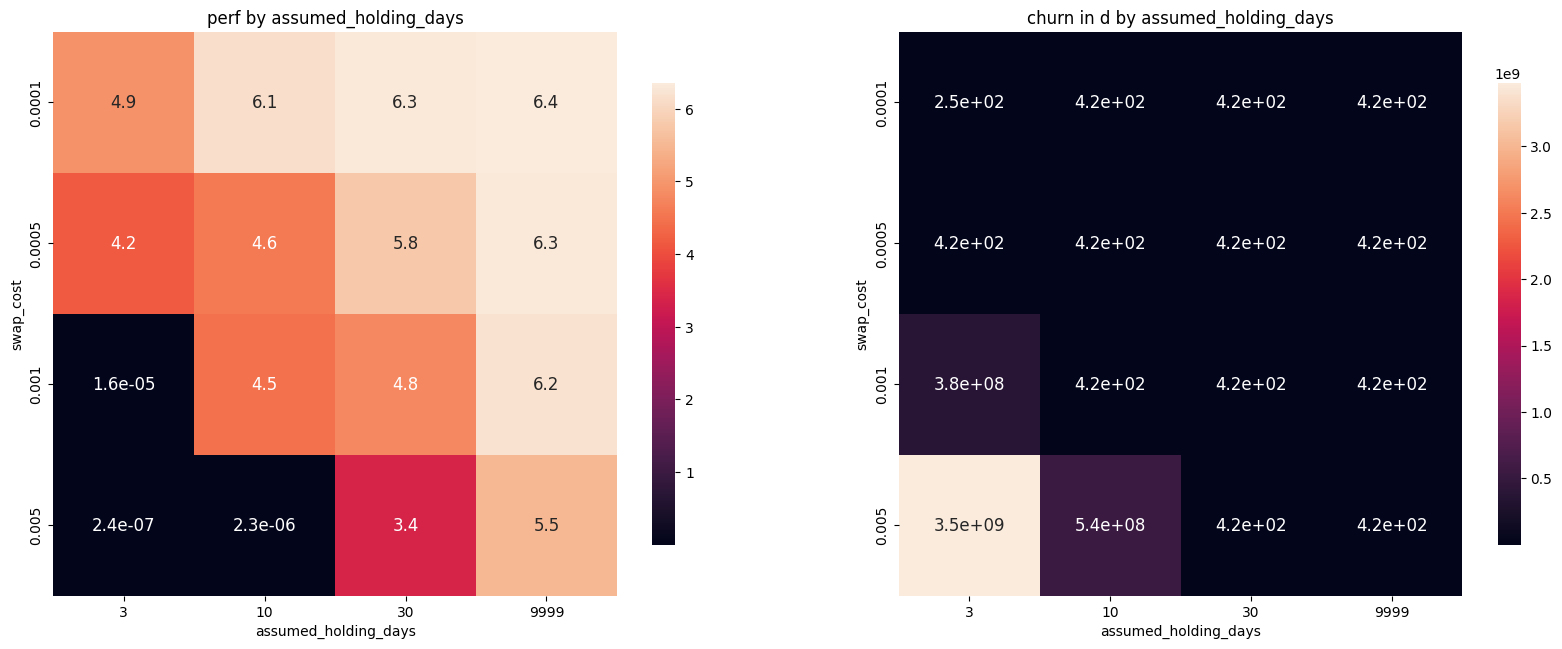

In [6]:
metrics = ['perf', 'churn in d']
ind = ['swap_cost']
col = ['assumed_holding_days']
display_heatmap(metrics, ind, col)

## cost x cost_blind_optimization

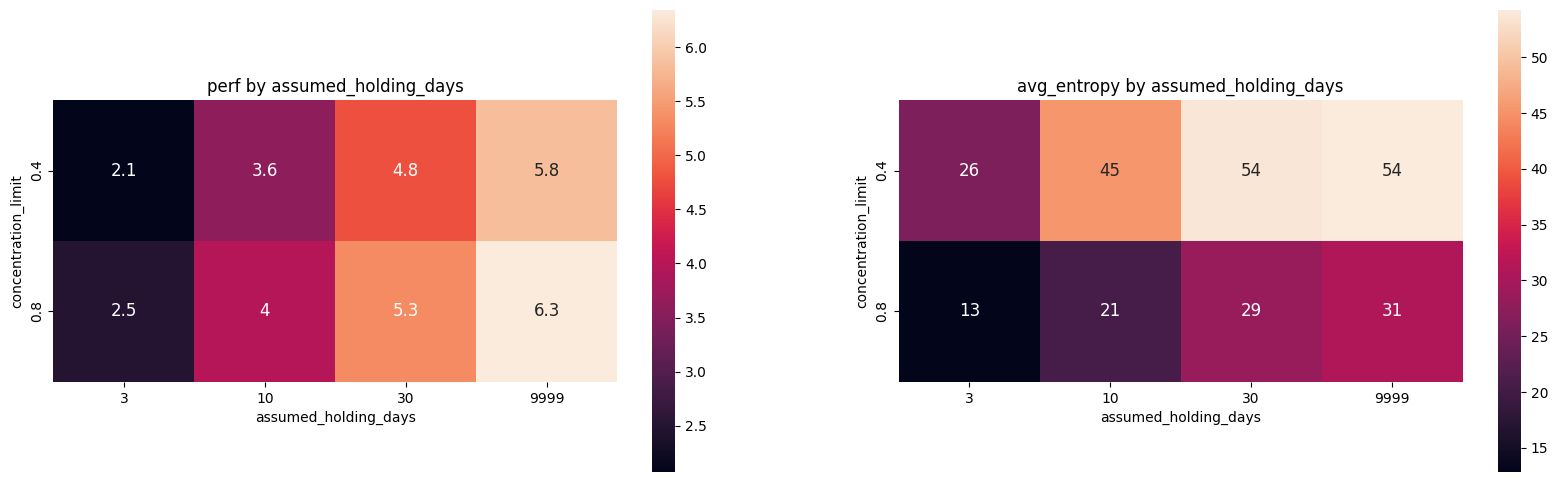

In [7]:
metrics = ['perf', 'avg_entropy']
ind = ['concentration_limit']
col = ['assumed_holding_days']
display_heatmap(metrics, ind, col)